## Preprocessing

In [85]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import tqdm
from timeit import default_timer as timer

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate

In [86]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [87]:
df = pd.read_csv('./data/Genus_DESL.csv')

In [88]:
df.head()

,Index,DESL,Corynebacterium,Staphylococcus,Propionibacterium,sp50014,Moraxella,Blautia,sp50017,sp5276,...,Light treatment,OSDI score,DEQ5 score,TBUT OD,TBUT OS,OSS OD,OSS OS,ST OD,ST OS,Demodicosis
0,P1,3,0.092816,0.001058,0.042075,0.0,0.0,0.000000,0.0,0.000000,...,0,NaN,NaN,3,3,0,0,23,23,0
1,P2,3,0.698862,0.001191,0.004366,0.0,0.0,0.000000,0.0,0.000000,...,0,31.25,17.0,2,4,1,3,14,18,0
2,P3,2,0.034017,0.259365,0.003640,0.0,0.0,0.000000,0.0,0.000000,...,1,33.30,16.0,8,8,3,3,11,8,0
3,P4,3,0.029042,0.177362,0.015877,0.0,0.0,0.127216,0.0,0.000000,...,0,93.75,21.0,3,2,2,2,12,11,0
4,P5,1,0.307662,0.164086,0.050351,0.0,0.0,0.000331,0.0,0.000463,...,1,6.25,7.0,11,11,0,0,22,32,0


In [89]:
df.iloc[:,2:600]

,Corynebacterium,Staphylococcus,Propionibacterium,sp50014,Moraxella,Blautia,sp50017,sp5276,Finegoldia,Acinetobacter,...,Dyella,Actinopolymorpha,Trichococcus,melongena,Methylophilus,Murdochiella,Intrasporangium,sp10518,sp44151,Limnobacter
0,0.092816,0.001058,0.042075,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.006020,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
1,0.698862,0.001191,0.004366,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
2,0.034017,0.259365,0.003640,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
3,0.029042,0.177362,0.015877,0.000000,0.0,0.127216,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
4,0.307662,0.164086,0.050351,0.000000,0.0,0.000331,0.0,0.000463,0.0,0.002183,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.358462,0.185519,0.108214,0.016877,0.0,0.000397,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
57,0.077600,0.355253,0.048227,0.000000,0.0,0.006814,0.0,0.036518,0.0,0.001125,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
58,0.296309,0.601019,0.004895,0.000000,0.0,0.004631,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
59,0.834877,0.046375,0.005028,0.000000,0.0,0.008997,0.0,0.004829,0.0,0.006285,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0


In [90]:
df.iloc[:,1]

0     3
1     3
2     2
3     3
4     1
     ..
56    3
57    2
58    2
59    2
60    3
Name: DESL, Length: 61, dtype: int64

In [91]:
X = df.iloc[:,2:600]
y = df.iloc[:,1]

## Train, predict and explain

### XGBoost

In [92]:
le = LabelEncoder()
y_xgb = le.fit_transform(y)


clfxgb = XGBClassifier(random_state=42)
looxgb = LeaveOneOut()
xgb_scores = cross_validate(clfxgb, X, y_xgb, cv=looxgb, scoring='accuracy', return_estimator=True)


In [93]:
xgb_scores

{'fit_time': array([0.3132689 , 0.3185904 , 0.32008457, 0.31690121, 0.31180358,
        0.32028031, 0.30964851, 0.3012135 , 0.31400394, 0.31874681,
        0.31347203, 0.32424855, 0.31342959, 0.32027936, 0.31567883,
        0.33182192, 0.3293283 , 0.31541133, 0.32933736, 0.31403255,
        0.32650232, 0.34405088, 0.32046437, 0.3493824 , 0.3322165 ,
        0.33013201, 0.31745076, 0.33142185, 0.32255363, 0.33816028,
        0.32120061, 0.33112788, 0.34765172, 0.32603431, 0.33938742,
        0.32945704, 0.33941126, 0.33276367, 0.33310318, 0.33163118,
        0.3416121 , 0.33464313, 0.32705116, 0.33938885, 0.32845998,
        0.33383942, 0.32625151, 0.32592535, 0.33643985, 0.31476378,
        0.32121325, 0.32176614, 0.33555341, 0.3251977 , 0.33858395,
        0.33153772, 0.33014798, 0.32184649, 0.33044791, 0.312958  ,
        0.33148503]),
 'score_time': array([0.0199995 , 0.02001262, 0.02000165, 0.0199976 , 0.0200243 ,
        0.02000022, 0.02000141, 0.03002667, 0.02207446, 0.02055287,


In [94]:
feature_importances_complete = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

The most important features for estimator 0:
                              Importance
Variovorax                      0.098368
BurkholderiaParaburkholderia    0.051287
sp35665                         0.048631
Cloacibacterium                 0.047529
sp30425                         0.042475
...                                  ...
sp35239                         0.000000
Aureimonas                      0.000000
Jatrophihabitans                0.000000
Lysinibacillus                  0.000000
Limnobacter                     0.000000

[598 rows x 1 columns]
The most important features for estimator 1:
                  Importance
Variovorax          0.067390
sp30425             0.061034
Aerococcus          0.060757
Lactococcus         0.053936
Cloacibacterium     0.053312
...                      ...
sp35190             0.000000
sp35239             0.000000
Aureimonas          0.000000
Jatrophihabitans    0.000000
Limnobacter         0.000000

[598 rows x 1 columns]
The most important fea

In [95]:
feature_importances_complete

,Importance
Variovorax,0.098368
BurkholderiaParaburkholderia,0.051287
sp35665,0.048631
Cloacibacterium,0.047529
sp30425,0.042475
...,...
Aureimonas,0.000000
Jatrophihabitans,0.000000
Lysinibacillus,0.000000
sp35669,0.000000


In [96]:
feature_importances_complete.shape

(36478, 1)

In [97]:
fic = feature_importances_complete.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [98]:
fic[:15]

,Importance
Variovorax,0.074605
Cloacibacterium,0.051026
Comamonas,0.041495
sp30425,0.040010
Aerococcus,0.039681
Nitriliruptor,0.034739
BurkholderiaParaburkholderia,0.031745
Bradyrhizobium,0.031368
Lactococcus,0.030195
Microbacterium,0.029873


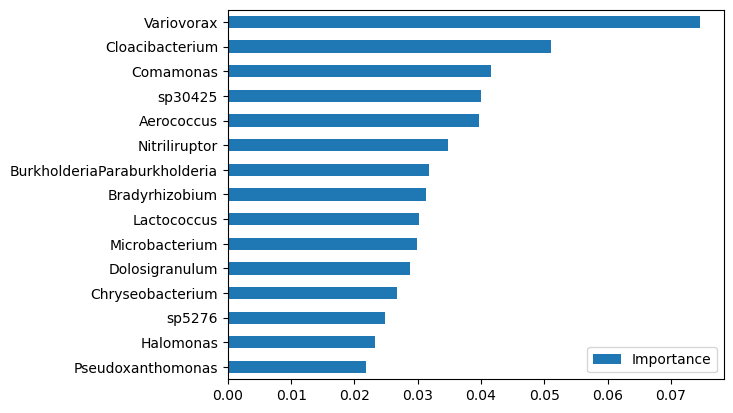

In [99]:
plot_fic = fic[:15]
plot_fic.plot(kind='barh').invert_yaxis()

In [100]:
# Calculate the SHAP values for every estimator 
for idx, estimator in enumerate(xgb_scores['estimator']):
    xgbshap = estimator.fit(X, y_xgb)
    explainerxgb = shap.Explainer(xgbshap, X)
    shap_valuesxgb = explainerxgb.shap_values(X.iloc[:,:])
    
    

In [102]:
np.shape(shap_valuesxgb)

(4, 61, 598)

In [103]:
shap_valuesxgb_mean = np.mean(shap_valuesxgb, axis=1)

In [104]:
np.shape(shap_valuesxgb_mean)

(4, 598)

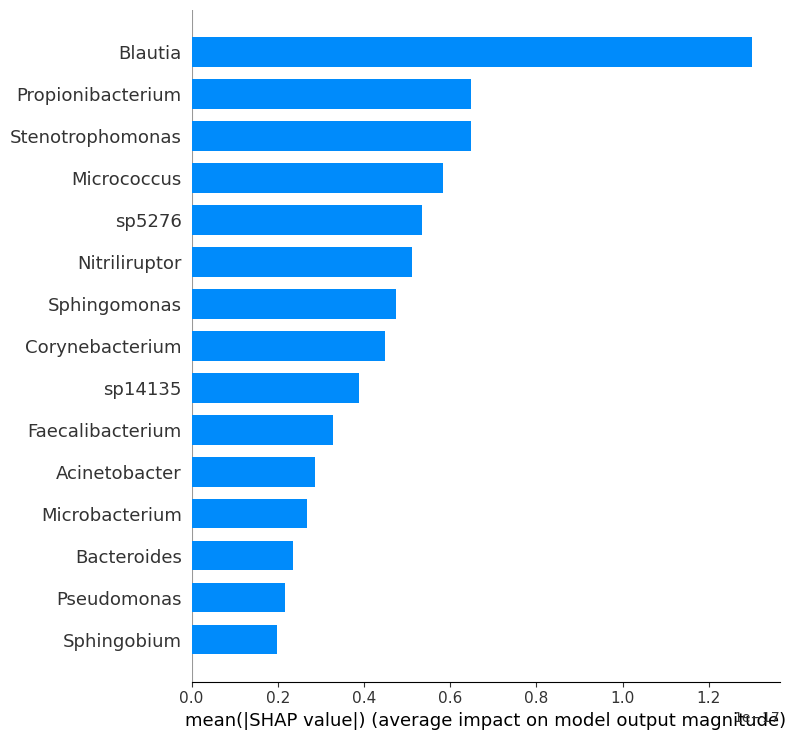

In [105]:
shap.summary_plot(shap_valuesxgb_mean, X, plot_type='bar', max_display=15)

### LightGBM

In [106]:
clflgbm = LGBMClassifier(random_state=42)
loolgbm = LeaveOneOut()
lgbm_scores = cross_validate(clflgbm, X, y, cv=loolgbm, scoring='accuracy', return_estimator=True)

In [107]:
lgbm_scores

{'fit_time': array([0.05240774, 0.03540134, 0.04247689, 0.02735353, 0.02749109,
        0.03436399, 0.03547335, 0.03236198, 0.02708268, 0.03291607,
        0.04152966, 0.03154421, 0.04030991, 0.03813553, 0.03634381,
        0.03628564, 0.03632331, 0.03050208, 0.0307672 , 0.03031301,
        0.03632379, 0.04847813, 0.04790068, 0.036201  , 0.03071547,
        0.05445147, 0.05443764, 0.03295422, 0.03631353, 0.03634334,
        0.03625035, 0.03630972, 0.03633189, 0.04243302, 0.03630424,
        0.03074574, 0.03025436, 0.03625703, 0.03485298, 0.03026462,
        0.03076839, 0.03679633, 0.05132413, 0.03631401, 0.03619146,
        0.036304  , 0.05447507, 0.03639817, 0.03647518, 0.03617406,
        0.03640842, 0.0302732 , 0.03629565, 0.03629136, 0.03638101,
        0.03927183, 0.03626704, 0.03375626, 0.03633475, 0.03637338,
        0.05443215]),
 'score_time': array([0.00496507, 0.00087404, 0.00422859, 0.        , 0.00583553,
        0.00483656, 0.00409508, 0.00400352, 0.00950313, 0.        ,


In [110]:
feature_importances_complete_lgb = []

for idx, estimator in enumerate(lgbm_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances_lgb = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances_lgb)
    feature_importances_complete_lgb.append(feature_importances_lgb)

feature_importances_complete_lgb = pd.concat(feature_importances_complete_lgb)

The most important features for estimator 0:
                               Importance
Corynebacterium                        97
Blautia                                80
Propionibacterium                      78
Pseudomonas                            51
Micrococcus                            46
...                                   ...
Pontibacter                             0
Rahnella                                0
Modestobacter                           0
EscherichiaShigellaSalmonella           0
Limnobacter                             0

[598 rows x 1 columns]
The most important features for estimator 1:
                               Importance
Corynebacterium                        96
Blautia                                81
Propionibacterium                      61
Bacteroides                            51
Pseudomonas                            51
...                                   ...
Rahnella                                0
Modestobacter                           0
Esch

In [111]:
feature_importances_complete_lgb

,Importance
Corynebacterium,97
Blautia,80
Propionibacterium,78
Pseudomonas,51
Micrococcus,46
...,...
Rahnella,0
Modestobacter,0
EscherichiaShigellaSalmonella,0
Prevotella,0


In [112]:
fic_lgb = feature_importances_complete_lgb.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [114]:
fic_lgb[:15]

,Importance
Corynebacterium,89.852459
Blautia,81.852459
Propionibacterium,72.901639
Pseudomonas,51.049180
Micrococcus,46.426230
Staphylococcus,45.885246
Bacteroides,43.016393
Faecalibacterium,40.557377
Acinetobacter,37.409836
Sphingomonas,24.524590


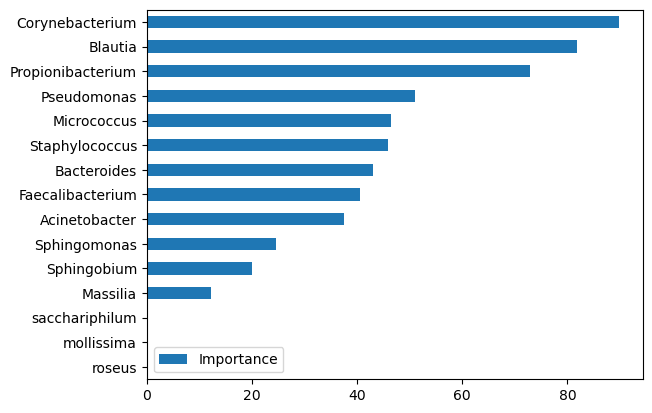

In [115]:
plot_fic_lgb = fic_lgb[:15]
plot_fic_lgb.plot(kind='barh').invert_yaxis()

In [116]:
# Calculate the SHAP values for every estimator 
for idx, estimator in enumerate(lgbm_scores['estimator']):
    lgbshap = estimator.fit(X, y)
    explainerlgb = shap.Explainer(lgbshap, X)
    shap_valueslgb = explainerlgb.shap_values(X.iloc[:,:])
    
    

In [117]:
np.shape(shap_valueslgb)

(4, 61, 598)

In [118]:
shap_valueslgb_mean = np.mean(shap_valueslgb, axis=1)

In [119]:
np.shape(shap_valueslgb_mean)

(4, 598)

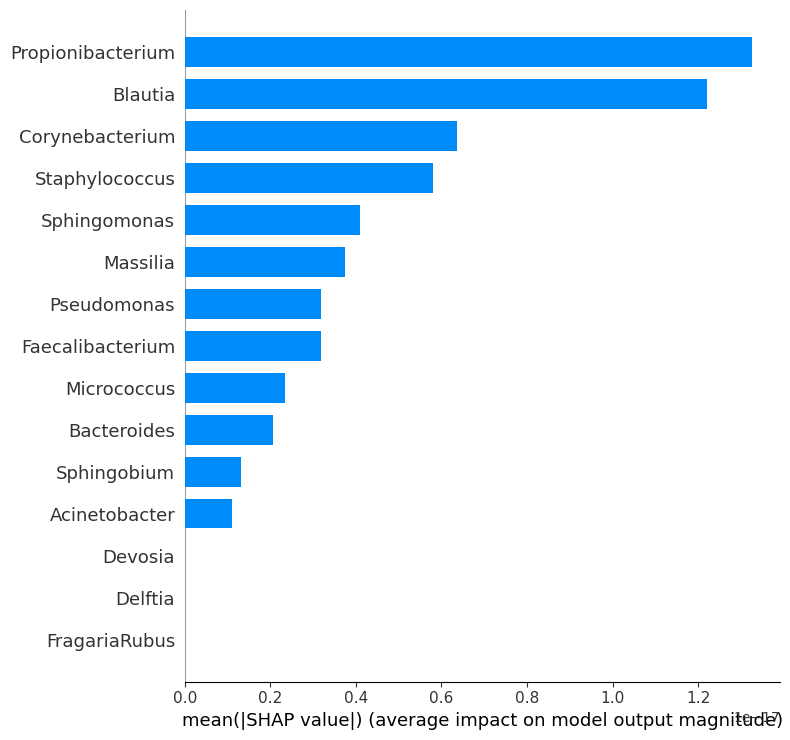

In [120]:
shap.summary_plot(shap_valueslgb_mean, X, plot_type='bar', max_display=15)

### Multilayer perceptron 

In [ ]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=3000, verbose=False)
clfmlp.out_activation_="softmax"

loomlp = LeaveOneOut()
mlp_scores = cross_validate(clfmlp, X, y, cv=loomlp, scoring='accuracy', return_estimator=True)

In [ ]:
mlp_scores

In [ ]:
# Every estimator in mlp_scores need to be fitted and permutation importance run on each estimator.

for idx, estimator in enumerate(mlp_scores['estimator']):
    mlpshap = estimator.fit(X, y)
    result = permutation_importance(mlpshap,X, y,n_repeats=1, random_state = 42)
    MLPfeatures = pd.DataFrame(mlpshap.feature_names_in_,columns=['Features'])
    MLPfeatures['Importance'] = result.importances_mean.tolist()
    #Sort by importance
    MLPfeatures = MLPfeatures.sort_values(by = 'Importance',ascending=False)
    print(f'The most important features for estimator {idx}:')
    print(MLPfeatures)